In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Packages Part
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
wineQuality_data='/workspaces/repo-project/Wine-Quality-tool/winequality-red.csv'

In [3]:
wine_df= pd.read_csv(wineQuality_data)

In [4]:
wine_df.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5


# Data understanding 

In [5]:
wine_df.count()

fixed acidity           1599
volatile acidity        1599
citric acid             1599
residual sugar          1599
chlorides               1599
free sulfur dioxide     1599
total sulfur dioxide    1599
density                 1599
pH                      1599
sulphates               1599
alcohol                 1599
quality                 1599
dtype: int64

In [6]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
wine_df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# function to standarise column names 

In [8]:
def column_name_standard(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df

In [9]:
column_name_standard(wine_df)
wine_df.head(2)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5


In [10]:
# Defining a function to calculate importance of features
def mutual_info_all(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    encoded = X.copy()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype.name == 'category':
            le = LabelEncoder()
            encoded[col] = le.fit_transform(X[col].astype(str))
        else:
            encoded[col] = X[col].fillna(X[col].median())

    mi = mutual_info_regression(encoded, y, discrete_features='auto')

    result = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    return result

In [11]:
mi_scores = mutual_info_all(wine_df, target='quality')
print(mi_scores)

alcohol                 0.175862
volatile_acidity        0.130156
sulphates               0.114402
density                 0.088914
citric_acid             0.054380
total_sulfur_dioxide    0.052458
fixed_acidity           0.039531
chlorides               0.029834
free_sulfur_dioxide     0.014229
ph                      0.013065
residual_sugar          0.012742
dtype: float64


# Treat quality column to 0,1 

In [12]:
print(wine_df['quality'].value_counts())

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


C:\Users\samik\AppData\Local\Temp\ipykernel_24256\3733533760.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=wine_df, palette='viridis')


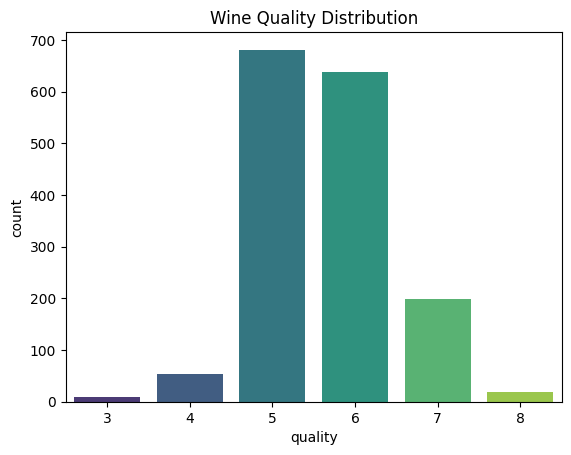

In [13]:
sns.countplot(x='quality', data=wine_df, palette='viridis')
plt.title("Wine Quality Distribution")
plt.show()

In [14]:
wine_df['good_quality'] = [1 if q >= 7 else 0 for q in wine_df['quality']]
wine_df.drop('quality', axis=1, inplace=True)
print(wine_df.head())

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  good_quality  
0      9.4             0  
1      9.8             0  
2    

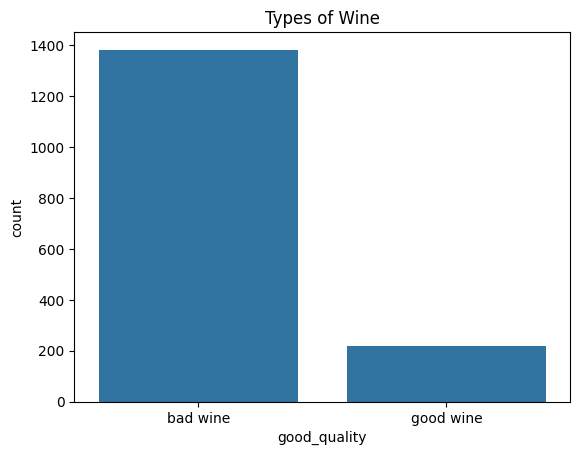

In [15]:
sns.countplot(data = wine_df, x = 'good_quality')
plt.xticks([0,1], ['bad wine','good wine'])
plt.title("Types of Wine")
plt.show()

In [16]:
xi = wine_df.corrwith(wine_df.good_quality).abs()
xi.sort_values(ascending=False)

good_quality            1.000000
alcohol                 0.407315
volatile_acidity        0.270712
citric_acid             0.214716
sulphates               0.199485
density                 0.150460
total_sulfur_dioxide    0.139517
fixed_acidity           0.120061
chlorides               0.097308
free_sulfur_dioxide     0.071747
ph                      0.057283
residual_sugar          0.047779
dtype: float64

In [17]:
from imblearn.over_sampling import SMOTE


In [18]:
#parameter for requires seed
random_value = 1000
#Fixing the imbalance using SMOTE Technique
main_copy = wine_df.copy()
print('Original class distribution:')
print(main_copy['good_quality'].value_counts())
xf = main_copy.columns
X = main_copy.drop(['good_quality'],axis=1)
Y = main_copy['good_quality']

Original class distribution:
good_quality
0    1382
1     217
Name: count, dtype: int64


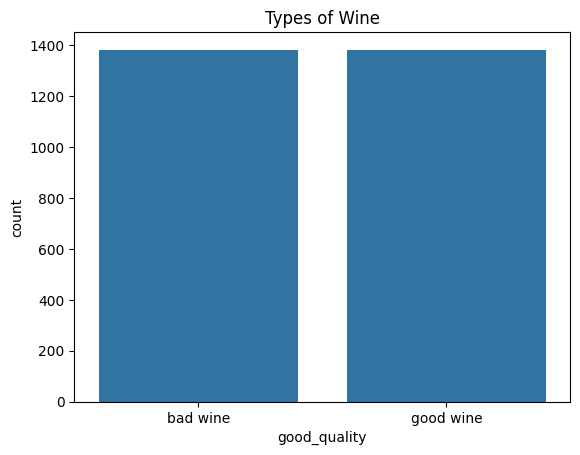

In [19]:
oversample = SMOTE()
X_ros, y_ros = oversample.fit_resample(X, Y)
sns.countplot(x=y_ros)
plt.xticks([0,1], ['bad wine','good wine'])
plt.title("Types of Wine")
plt.show()

In [20]:
# Step 1: Split off the test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=random_value)
# Step 2: Split the remaining 80% into train and validation (e.g. 60/20)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=random_value)  

In [21]:
len(X_train), len(X_val), len(X_test),len(y_train), len(y_val), len(y_test)

(1658, 553, 553, 1658, 553, 553)

In [22]:
X_train.head(2)
y_train.head(2)

1929    1
1536    0
Name: good_quality, dtype: int64

In [23]:
# Importing LogisticRegression and metrics from sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

In [24]:
# scale with StandardScaler
scaler = StandardScaler()
# fit to data training
scaler.fit(X_train)
# transform
x_train_scaled = scaler.transform(X_train)
x_val_scaled = scaler.transform(X_val)
x_test_scaled = scaler.transform(X_test)

# Logistics Regression

In [25]:
model1 = LogisticRegression(max_iter=1000, random_state=random_value)
model1.fit(x_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1000
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


In [27]:
y_val_pred = model1.predict(x_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8191681735985533

Confusion Matrix:
 [[216  56]
 [ 44 237]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       272
           1       0.81      0.84      0.83       281

    accuracy                           0.82       553
   macro avg       0.82      0.82      0.82       553
weighted avg       0.82      0.82      0.82       553



# testing the model on test data

In [28]:
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (1658, 11) (1658,)
Validation: (553, 11) (553,)
Test: (553, 11) (553,)


# Logistic regression with cross validation and finding the best C

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from tqdm import tqdm


random_value = 42
X_temp, X_test, y_temp, y_test = train_test_split(    X, Y, test_size=0.20, stratify=Y, random_state=random_value)
X_train, X_val, y_train, y_val = train_test_split(    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=random_value)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

sm = SMOTE(random_state=random_value)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Resampled Train:", X_train_res.shape)


scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(X_train_res)
x_val_scaled   = scaler.transform(X_val)
x_test_scaled  = scaler.transform(X_test)


C_values = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]
n_splits = 5

best_C = None
best_auc = -1

print("\n===== CROSS VALIDATION STARTED =====\n")

for C in tqdm(C_values):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_value)
    fold_scores = []

    for train_idx, val_idx in kfold.split(x_train_scaled):

        X_fold_train = x_train_scaled[train_idx]
        X_fold_val   = x_train_scaled[val_idx]

        y_fold_train = y_train_res.iloc[train_idx]
        y_fold_val   = y_train_res.iloc[val_idx]

        model = LogisticRegression(
            max_iter=2000,
            random_state=random_value,
            C=C,
            solver='lbfgs'
        )

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)

        auc = roc_auc_score(y_fold_val, y_pred)
        fold_scores.append(auc)

    mean_auc = np.mean(fold_scores)
    print(f"C={C} → AUC={mean_auc:.4f}")

    if mean_auc > best_auc:
        best_auc = mean_auc
        best_C = C

print("\nBest C value:", best_C)






Train: (959, 11)
Validation: (320, 11)
Test: (320, 11)
Resampled Train: (1658, 11)

===== CROSS VALIDATION STARTED =====



  0%|                                                                          | 0/7 [00:00<?, ?it/s]

C=0.001 → AUC=0.7933
C=0.01 → AUC=0.7991


 57%|█████████████████████████████████████▋                            | 4/7 [00:00<00:00,  9.98it/s]

C=0.1 → AUC=0.8142
C=0.5 → AUC=0.8148


 86%|████████████████████████████████████████████████████████▌         | 6/7 [00:00<00:00,  9.55it/s]

C=1 → AUC=0.8142
C=5 → AUC=0.8136


100%|██████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.64it/s]

C=10 → AUC=0.8136

Best C value: 0.5


In [30]:
final_model = LogisticRegression(
    C=0.5,
    max_iter=2000,
    random_state=random_value
)

final_model.fit(x_train_scaled, y_train_res)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.5
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [31]:
# ============================================
# 8. VALIDATION EVALUATION
# ============================================
print("\n===== VALIDATION RESULTS =====")
y_val_pred = final_model.predict(x_val_scaled)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation AUC:", roc_auc_score(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))


# ============================================
# 9. FINAL TEST SET EVALUATION
# ============================================
print("\n===== TEST RESULTS =====")
y_test_pred = final_model.predict(x_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


===== VALIDATION RESULTS =====
Validation Accuracy: 0.821875
Validation AUC: 0.8203227931488801

Confusion Matrix:
 [[227  49]
 [  8  36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89       276
           1       0.42      0.82      0.56        44

    accuracy                           0.82       320
   macro avg       0.69      0.82      0.72       320
weighted avg       0.89      0.82      0.84       320


===== TEST RESULTS =====
Test Accuracy: 0.828125
Test AUC: 0.8221391990596928

Confusion Matrix:
 [[230  47]
 [  8  35]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.83      0.89       277
           1       0.43      0.81      0.56        43

    accuracy                           0.83       320
   macro avg       0.70      0.82      0.73       320
weighted avg       0.89      0.83      0.85       320



# random forest classifier with cross validation and finding the best depth

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

random_value = 42
X_temp, X_test, y_temp, y_test = train_test_split(    X, Y, test_size=0.20, stratify=Y, random_state=random_value)
X_train, X_val, y_train, y_val = train_test_split(    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=random_value)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

sm = SMOTE(random_state=random_value)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Resampled Train:", X_train_res.shape)


scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(X_train_res)
x_val_scaled   = scaler.transform(X_val)
x_test_scaled  = scaler.transform(X_test)
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

n_splits = 5
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_value)
    scores = []
    
    for train_idx, val_idx in kfold.split(x_train_scaled):
        
        X_fold_train = x_train_scaled[train_idx]
        X_fold_val   = x_train_scaled[val_idx]
        y_fold_train = y_train_res.iloc[train_idx]
        y_fold_val   = y_train_res.iloc[val_idx]
        
        model = LogisticRegression(
            max_iter=1000,
            random_state=random_value,
            C=C,
            solver='lbfgs'
        )

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        
        auc = roc_auc_score(y_fold_val, y_pred)
        scores.append(auc)
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
    

scores
#c = 0.01 

model_LR = LogisticRegression(max_iter=1000, random_state=random_value, C=.5)
model_LR.fit(x_train_scaled, y_train)
y_pred = model_LR.predict(x_test_scaled)
auc = roc_auc_score(y_val, y_pred)

auc

y_test_pred = model.predict(x_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

auc

# Random Forest Classifier

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

In [33]:
X_train.shape , X_val.shape ,X_test.shape , X_ros.shape

((959, 11), (320, 11), (320, 11), (2764, 11))

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

# 20% test, 60% train, 20% validation
X_temp, X_test, y_temp, y_test = train_test_split(
    X_ros, y_ros, test_size=0.2, random_state=random_value, stratify=y_ros
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=random_value, stratify=y_temp
)
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (1658, 11) (1658,)
Validation: (553, 11) (553,)
Test: (553, 11) (553,)


In [35]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_value)

n_estimators_list = [50, 100, 150, 200]
max_depth_list = [2, 4, 6, 8, 10, None]

results = []
best_auc = -1
best_params = None

print("\nStarting hyperparameter search...\n")

for max_depth in max_depth_list:
    for n_estimators in tqdm(n_estimators_list, desc=f"max_depth={max_depth}"):

        fold_aucs = []

        for train_idx, val_idx in kfold.split(X_train):

            X_fold_train = X_train.iloc[train_idx]
            y_fold_train = y_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            y_fold_val = y_train.iloc[val_idx]

            # Apply SMOTE inside each fold to avoid data leakage
            sm = SMOTE(random_state=random_value)
            X_res, y_res = sm.fit_resample(X_fold_train, y_fold_train)

            # Train Random Forest
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=random_value,
                n_jobs=-1
            )
            rf.fit(X_res, y_res)

            # Predict probabilities (required for ROC-AUC)
            y_pred = rf.predict_proba(X_fold_val)[:, 1]
            auc = roc_auc_score(y_fold_val, y_pred)
            fold_aucs.append(auc)

        mean_auc = np.mean(fold_aucs)

        print(f"max_depth={max_depth}, n_estimators={n_estimators}, AUC={mean_auc:.4f}")

        # Track best model
        if mean_auc > best_auc:
            best_auc = mean_auc
            best_params = (max_depth, n_estimators)

        results.append((max_depth, n_estimators, mean_auc))

print("\nBest Hyperparameters:")
print("Max Depth:", best_params[0])
print("Estimators:", best_params[1])
print(f"Best CV AUC: {best_auc:.4f}")



Starting hyperparameter search...



max_depth=2:  25%|█████████████▎                                       | 1/4 [00:02<00:06,  2.15s/it]

max_depth=2, n_estimators=50, AUC=0.9038


max_depth=2:  50%|██████████████████████████▌                          | 2/4 [00:05<00:05,  2.74s/it]

max_depth=2, n_estimators=100, AUC=0.9046


max_depth=2:  75%|███████████████████████████████████████▊             | 3/4 [00:09<00:03,  3.41s/it]

max_depth=2, n_estimators=150, AUC=0.9045


max_depth=2: 100%|█████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.48s/it]


max_depth=2, n_estimators=200, AUC=0.9051


max_depth=4:  25%|█████████████▎                                       | 1/4 [00:00<00:02,  1.05it/s]

max_depth=4, n_estimators=50, AUC=0.9282


max_depth=4:  50%|██████████████████████████▌                          | 2/4 [00:02<00:02,  1.12s/it]

max_depth=4, n_estimators=100, AUC=0.9277


max_depth=4:  75%|███████████████████████████████████████▊             | 3/4 [00:03<00:01,  1.37s/it]

max_depth=4, n_estimators=150, AUC=0.9281


max_depth=4: 100%|█████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/it]


max_depth=4, n_estimators=200, AUC=0.9287


max_depth=6:  25%|█████████████▎                                       | 1/4 [00:00<00:02,  1.17it/s]

max_depth=6, n_estimators=50, AUC=0.9506


max_depth=6:  50%|██████████████████████████▌                          | 2/4 [00:02<00:02,  1.17s/it]

max_depth=6, n_estimators=100, AUC=0.9519


max_depth=6:  75%|███████████████████████████████████████▊             | 3/4 [00:04<00:01,  1.48s/it]

max_depth=6, n_estimators=150, AUC=0.9513


max_depth=6: 100%|█████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.58s/it]


max_depth=6, n_estimators=200, AUC=0.9515


max_depth=8:  25%|█████████████▎                                       | 1/4 [00:00<00:02,  1.37it/s]

max_depth=8, n_estimators=50, AUC=0.9648


max_depth=8:  50%|██████████████████████████▌                          | 2/4 [00:02<00:02,  1.07s/it]

max_depth=8, n_estimators=100, AUC=0.9652


max_depth=8:  75%|███████████████████████████████████████▊             | 3/4 [00:03<00:01,  1.40s/it]

max_depth=8, n_estimators=150, AUC=0.9661


max_depth=8: 100%|█████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.52s/it]


max_depth=8, n_estimators=200, AUC=0.9665


max_depth=10:  25%|█████████████                                       | 1/4 [00:00<00:02,  1.29it/s]

max_depth=10, n_estimators=50, AUC=0.9716


max_depth=10:  50%|██████████████████████████                          | 2/4 [00:02<00:02,  1.05s/it]

max_depth=10, n_estimators=100, AUC=0.9726


max_depth=10:  75%|███████████████████████████████████████             | 3/4 [00:04<00:01,  1.49s/it]

max_depth=10, n_estimators=150, AUC=0.9725


max_depth=10: 100%|████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.61s/it]


max_depth=10, n_estimators=200, AUC=0.9727


max_depth=None:  25%|████████████▌                                     | 1/4 [00:00<00:02,  1.26it/s]

max_depth=None, n_estimators=50, AUC=0.9755


max_depth=None:  50%|█████████████████████████                         | 2/4 [00:02<00:02,  1.15s/it]

max_depth=None, n_estimators=100, AUC=0.9761


max_depth=None:  75%|█████████████████████████████████████▌            | 3/4 [00:04<00:01,  1.50s/it]

max_depth=None, n_estimators=150, AUC=0.9770


max_depth=None: 100%|██████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]

max_depth=None, n_estimators=200, AUC=0.9773

Best Hyperparameters:
Max Depth: None
Estimators: 200
Best CV AUC: 0.9773


In [36]:

# ------------------------------------------------------------
# 5. TRAIN FINAL MODEL ON TRAINING + SMOTE
# ------------------------------------------------------------

print("\nTraining final model...")

best_max_depth, best_n_estimators = best_params

sm = SMOTE(random_state=random_value)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

final_rf = RandomForestClassifier(
    max_depth=best_max_depth,
    n_estimators=best_n_estimators,
    random_state=random_value,
    n_jobs=-1
)

final_rf.fit(X_train_res, y_train_res)

# ------------------------------------------------------------
# 6. EVALUATION (VALIDATION + TEST)
# ------------------------------------------------------------

def evaluate(model, X, y, name="Set"):

    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred_class = model.predict(X)

    auc = roc_auc_score(y, y_pred_prob)
    acc = accuracy_score(y, y_pred_class)

    print(f"\n{name} Evaluation:")
    print(f"AUC:  {auc:.4f}")
    print(f"ACC:  {acc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred_class))
    print("\nClassification Report:")
    print(classification_report(y, y_pred_class))

# Evaluate
evaluate(final_rf, X_val, y_val, "Validation")
evaluate(final_rf, X_test, y_test, "Test")



Training final model...

Validation Evaluation:
AUC:  0.9740
ACC:  0.9024
Confusion Matrix:
[[232  44]
 [ 10 267]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       276
           1       0.86      0.96      0.91       277

    accuracy                           0.90       553
   macro avg       0.91      0.90      0.90       553
weighted avg       0.91      0.90      0.90       553


Test Evaluation:
AUC:  0.9885
ACC:  0.9421
Confusion Matrix:
[[255  22]
 [ 10 266]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       277
           1       0.92      0.96      0.94       276

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



# Decision Tree Classifier

In [37]:
# ------------------------------------------------------------
#  DECISION TREE CLASSIFIER FOR WINE QUALITY (FULL PIPELINE)
# ------------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    classification_report,
    confusion_matrix
)
from imblearn.over_sampling import SMOTE
from tqdm import tqdm


# 20% test, 60% train, 20% validation
X_temp, X_test, y_temp, y_test = train_test_split(
    X_ros, y_ros, test_size=0.2, random_state=random_value, stratify=y_ros
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=random_value, stratify=y_temp
)
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

# ------------------------------------------------------------
# 4. HYPERPARAMETER TUNING WITH K-FOLD CV + SMOTE
# ------------------------------------------------------------

# Decision Tree hyperparameter grid
max_depth_list   = [2, 4, 6, 8, 10, 20, None]
min_samples_split_list = [2, 5, 10, 20]
min_samples_leaf_list  = [1, 2, 4, 8]

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_value)

results = []
best_auc = -1
best_params = None

print("\nStarting hyperparameter search...\n")

for depth in max_depth_list:
    for min_split in min_samples_split_list:
        for min_leaf in tqdm(min_samples_leaf_list,
                             desc=f"depth={depth}, min_split={min_split}"):

            fold_aucs = []

            for train_idx, val_idx in kfold.split(X_train):

                X_fold_train = X_train.iloc[train_idx]
                y_fold_train = y_train.iloc[train_idx]
                X_fold_val   = X_train.iloc[val_idx]
                y_fold_val   = y_train.iloc[val_idx]

                # SMOTE only on training fold
                sm = SMOTE(random_state=random_value)
                X_res, y_res = sm.fit_resample(X_fold_train, y_fold_train)

                # Train Decision Tree
                dt = DecisionTreeClassifier(
                    max_depth=depth,
                    min_samples_split=min_split,
                    min_samples_leaf=min_leaf,
                    random_state=random_value
                )
                dt.fit(X_res, y_res)

                # Predict probabilities for ROC-AUC
                y_pred = dt.predict_proba(X_fold_val)[:, 1]
                auc = roc_auc_score(y_fold_val, y_pred)
                fold_aucs.append(auc)

            mean_auc = np.mean(fold_aucs)

            results.append((depth, min_split, min_leaf, mean_auc))

            print(f"depth={depth}, min_split={min_split}, "
                  f"min_leaf={min_leaf}, AUC={mean_auc:.4f}")

            # Track the best parameters
            if mean_auc > best_auc:
                best_auc = mean_auc
                best_params = (depth, min_split, min_leaf)

print("\nBest Hyperparameters Found:")
print("Max Depth:", best_params[0])
print("Min Samples Split:", best_params[1])
print("Min Samples Leaf:", best_params[2])
print(f"Best CV AUC: {best_auc:.4f}")





Train: (1658, 11) (1658,)
Validation: (553, 11) (553,)
Test: (553, 11) (553,)

Starting hyperparameter search...



depth=2, min_split=2:  50%|██████████████████████                      | 2/4 [00:00<00:00, 14.36it/s]

depth=2, min_split=2, min_leaf=1, AUC=0.8259
depth=2, min_split=2, min_leaf=2, AUC=0.8259
depth=2, min_split=2, min_leaf=4, AUC=0.8259


depth=2, min_split=2: 100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 14.99it/s]


depth=2, min_split=2, min_leaf=8, AUC=0.8259


depth=2, min_split=5:  50%|██████████████████████                      | 2/4 [00:00<00:00, 16.50it/s]

depth=2, min_split=5, min_leaf=1, AUC=0.8259
depth=2, min_split=5, min_leaf=2, AUC=0.8259
depth=2, min_split=5, min_leaf=4, AUC=0.8259


depth=2, min_split=5: 100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 14.76it/s]


depth=2, min_split=5, min_leaf=8, AUC=0.8259


depth=2, min_split=10:   0%|                                                   | 0/4 [00:00<?, ?it/s]

depth=2, min_split=10, min_leaf=1, AUC=0.8259
depth=2, min_split=10, min_leaf=2, AUC=0.8259


depth=2, min_split=10:  50%|█████████████████████▌                     | 2/4 [00:00<00:00, 15.29it/s]

depth=2, min_split=10, min_leaf=4, AUC=0.8259


depth=2, min_split=10: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 14.62it/s]


depth=2, min_split=10, min_leaf=8, AUC=0.8259


depth=2, min_split=20:   0%|                                                   | 0/4 [00:00<?, ?it/s]

depth=2, min_split=20, min_leaf=1, AUC=0.8259


depth=2, min_split=20:  50%|█████████████████████▌                     | 2/4 [00:00<00:00, 14.39it/s]

depth=2, min_split=20, min_leaf=2, AUC=0.8259
depth=2, min_split=20, min_leaf=4, AUC=0.8259


depth=2, min_split=20: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 13.30it/s]


depth=2, min_split=20, min_leaf=8, AUC=0.8259


depth=4, min_split=2:   0%|                                                    | 0/4 [00:00<?, ?it/s]

depth=4, min_split=2, min_leaf=1, AUC=0.8810


depth=4, min_split=2:  50%|██████████████████████                      | 2/4 [00:00<00:00, 11.49it/s]

depth=4, min_split=2, min_leaf=2, AUC=0.8827
depth=4, min_split=2, min_leaf=4, AUC=0.8819


depth=4, min_split=2: 100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 10.29it/s]


depth=4, min_split=2, min_leaf=8, AUC=0.8836


depth=4, min_split=5:   0%|                                                    | 0/4 [00:00<?, ?it/s]

depth=4, min_split=5, min_leaf=1, AUC=0.8810


depth=4, min_split=5:  50%|██████████████████████                      | 2/4 [00:00<00:00, 11.72it/s]

depth=4, min_split=5, min_leaf=2, AUC=0.8827
depth=4, min_split=5, min_leaf=4, AUC=0.8819


depth=4, min_split=5: 100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 12.01it/s]


depth=4, min_split=5, min_leaf=8, AUC=0.8836


depth=4, min_split=10:  25%|██████████▊                                | 1/4 [00:00<00:00,  8.85it/s]

depth=4, min_split=10, min_leaf=1, AUC=0.8810
depth=4, min_split=10, min_leaf=2, AUC=0.8827


depth=4, min_split=10:  75%|████████████████████████████████▎          | 3/4 [00:00<00:00, 11.34it/s]

depth=4, min_split=10, min_leaf=4, AUC=0.8819


depth=4, min_split=10: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 11.86it/s]


depth=4, min_split=10, min_leaf=8, AUC=0.8836


depth=4, min_split=20:   0%|                                                   | 0/4 [00:00<?, ?it/s]

depth=4, min_split=20, min_leaf=1, AUC=0.8820


depth=4, min_split=20:  50%|█████████████████████▌                     | 2/4 [00:00<00:00, 11.10it/s]

depth=4, min_split=20, min_leaf=2, AUC=0.8818
depth=4, min_split=20, min_leaf=4, AUC=0.8808


depth=4, min_split=20: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 11.31it/s]


depth=4, min_split=20, min_leaf=8, AUC=0.8836


depth=6, min_split=2:  25%|███████████                                 | 1/4 [00:00<00:00,  9.23it/s]

depth=6, min_split=2, min_leaf=1, AUC=0.8845


depth=6, min_split=2:  75%|█████████████████████████████████           | 3/4 [00:00<00:00,  9.88it/s]

depth=6, min_split=2, min_leaf=2, AUC=0.8933
depth=6, min_split=2, min_leaf=4, AUC=0.8975


depth=6, min_split=2: 100%|████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]

depth=6, min_split=2, min_leaf=8, AUC=0.8984



depth=6, min_split=5:  25%|███████████                                 | 1/4 [00:00<00:00,  9.83it/s]

depth=6, min_split=5, min_leaf=1, AUC=0.8880


depth=6, min_split=5:  75%|█████████████████████████████████           | 3/4 [00:00<00:00,  9.88it/s]

depth=6, min_split=5, min_leaf=2, AUC=0.8911
depth=6, min_split=5, min_leaf=4, AUC=0.8975


depth=6, min_split=5: 100%|████████████████████████████████████████████| 4/4 [00:00<00:00,  9.84it/s]


depth=6, min_split=5, min_leaf=8, AUC=0.8984


depth=6, min_split=10:  25%|██████████▊                                | 1/4 [00:00<00:00,  9.64it/s]

depth=6, min_split=10, min_leaf=1, AUC=0.8885


depth=6, min_split=10:  75%|████████████████████████████████▎          | 3/4 [00:00<00:00, 10.84it/s]

depth=6, min_split=10, min_leaf=2, AUC=0.8939
depth=6, min_split=10, min_leaf=4, AUC=0.8970


depth=6, min_split=10: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 11.12it/s]


depth=6, min_split=10, min_leaf=8, AUC=0.8984


depth=6, min_split=20:  50%|█████████████████████▌                     | 2/4 [00:00<00:00, 12.06it/s]

depth=6, min_split=20, min_leaf=1, AUC=0.8937
depth=6, min_split=20, min_leaf=2, AUC=0.8953
depth=6, min_split=20, min_leaf=4, AUC=0.9004


depth=6, min_split=20: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 11.46it/s]


depth=6, min_split=20, min_leaf=8, AUC=0.9016


depth=8, min_split=2:   0%|                                                    | 0/4 [00:00<?, ?it/s]

depth=8, min_split=2, min_leaf=1, AUC=0.8787
depth=8, min_split=2, min_leaf=2, AUC=0.8846

depth=8, min_split=2:  50%|██████████████████████                      | 2/4 [00:00<00:00, 11.12it/s]


depth=8, min_split=2, min_leaf=4, AUC=0.8963


depth=8, min_split=2: 100%|████████████████████████████████████████████| 4/4 [00:00<00:00,  9.81it/s]


depth=8, min_split=2, min_leaf=8, AUC=0.8998


depth=8, min_split=5:  25%|███████████                                 | 1/4 [00:00<00:00,  8.33it/s]

depth=8, min_split=5, min_leaf=1, AUC=0.8835


depth=8, min_split=5:  50%|██████████████████████                      | 2/4 [00:00<00:00,  7.90it/s]

depth=8, min_split=5, min_leaf=2, AUC=0.8877


depth=8, min_split=5:  75%|█████████████████████████████████           | 3/4 [00:00<00:00,  7.92it/s]

depth=8, min_split=5, min_leaf=4, AUC=0.8963


depth=8, min_split=5: 100%|████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


depth=8, min_split=5, min_leaf=8, AUC=0.8998


depth=8, min_split=10:  25%|██████████▊                                | 1/4 [00:00<00:00,  8.36it/s]

depth=8, min_split=10, min_leaf=1, AUC=0.8899


depth=8, min_split=10:  50%|█████████████████████▌                     | 2/4 [00:00<00:00,  7.69it/s]

depth=8, min_split=10, min_leaf=2, AUC=0.8948


depth=8, min_split=10:  75%|████████████████████████████████▎          | 3/4 [00:00<00:00,  7.28it/s]

depth=8, min_split=10, min_leaf=4, AUC=0.8979


depth=8, min_split=10: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


depth=8, min_split=10, min_leaf=8, AUC=0.8998


depth=8, min_split=20:  25%|██████████▊                                | 1/4 [00:00<00:00,  7.73it/s]

depth=8, min_split=20, min_leaf=1, AUC=0.8977


depth=8, min_split=20:  50%|█████████████████████▌                     | 2/4 [00:00<00:00,  8.60it/s]

depth=8, min_split=20, min_leaf=2, AUC=0.8999
depth=8, min_split=20, min_leaf=4, AUC=0.9016


depth=8, min_split=20: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00,  9.65it/s]


depth=8, min_split=20, min_leaf=8, AUC=0.9054


depth=10, min_split=2:   0%|                                                   | 0/4 [00:00<?, ?it/s]

depth=10, min_split=2, min_leaf=1, AUC=0.8622


depth=10, min_split=2:  50%|█████████████████████▌                     | 2/4 [00:00<00:00, 10.56it/s]

depth=10, min_split=2, min_leaf=2, AUC=0.8726
depth=10, min_split=2, min_leaf=4, AUC=0.8923


depth=10, min_split=2: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


depth=10, min_split=2, min_leaf=8, AUC=0.9027


depth=10, min_split=5:  25%|██████████▊                                | 1/4 [00:00<00:00,  6.66it/s]

depth=10, min_split=5, min_leaf=1, AUC=0.8671


depth=10, min_split=5: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]

depth=10, min_split=5, min_leaf=2, AUC=0.8758
depth=10, min_split=5, min_leaf=4, AUC=0.8923
depth=10, min_split=5, min_leaf=8, AUC=0.9027


depth=10, min_split=10:  50%|█████████████████████                     | 2/4 [00:00<00:00,  7.29it/s]

depth=10, min_split=10, min_leaf=1, AUC=0.8828
depth=10, min_split=10, min_leaf=2, AUC=0.8892


depth=10, min_split=10: 100%|██████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


depth=10, min_split=10, min_leaf=4, AUC=0.8920
depth=10, min_split=10, min_leaf=8, AUC=0.9027


depth=10, min_split=20:   0%|                                                  | 0/4 [00:00<?, ?it/s]

depth=10, min_split=20, min_leaf=1, AUC=0.8855

depth=10, min_split=20:  75%|███████████████████████████████▌          | 3/4 [00:00<00:00, 10.94it/s]


depth=10, min_split=20, min_leaf=2, AUC=0.8893
depth=10, min_split=20, min_leaf=4, AUC=0.8969


depth=10, min_split=20: 100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 10.38it/s]


depth=10, min_split=20, min_leaf=8, AUC=0.9091


depth=20, min_split=2:   0%|                                                   | 0/4 [00:00<?, ?it/s]

depth=20, min_split=2, min_leaf=1, AUC=0.8764


depth=20, min_split=2:  50%|█████████████████████▌                     | 2/4 [00:00<00:00, 10.02it/s]

depth=20, min_split=2, min_leaf=2, AUC=0.8781
depth=20, min_split=2, min_leaf=4, AUC=0.8944


depth=20, min_split=2: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


depth=20, min_split=2, min_leaf=8, AUC=0.8998


depth=20, min_split=5:   0%|                                                   | 0/4 [00:00<?, ?it/s]

depth=20, min_split=5, min_leaf=1, AUC=0.8829


depth=20, min_split=5:  50%|█████████████████████▌                     | 2/4 [00:00<00:00,  9.79it/s]

depth=20, min_split=5, min_leaf=2, AUC=0.8834


depth=20, min_split=5: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 10.13it/s]

depth=20, min_split=5, min_leaf=4, AUC=0.8944
depth=20, min_split=5, min_leaf=8, AUC=0.8998


depth=20, min_split=10:   0%|                                                  | 0/4 [00:00<?, ?it/s]

depth=20, min_split=10, min_leaf=1, AUC=0.8883

depth=20, min_split=10:  50%|█████████████████████                     | 2/4 [00:00<00:00,  8.46it/s]


depth=20, min_split=10, min_leaf=2, AUC=0.8890


depth=20, min_split=10: 100%|██████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


depth=20, min_split=10, min_leaf=4, AUC=0.8998
depth=20, min_split=10, min_leaf=8, AUC=0.8998


depth=20, min_split=20:  50%|█████████████████████                     | 2/4 [00:00<00:00,  9.26it/s]

depth=20, min_split=20, min_leaf=1, AUC=0.8978
depth=20, min_split=20, min_leaf=2, AUC=0.8908


depth=20, min_split=20: 100%|██████████████████████████████████████████| 4/4 [00:00<00:00,  9.76it/s]


depth=20, min_split=20, min_leaf=4, AUC=0.8995
depth=20, min_split=20, min_leaf=8, AUC=0.9084


depth=None, min_split=2:   0%|                                                 | 0/4 [00:00<?, ?it/s]

depth=None, min_split=2, min_leaf=1, AUC=0.8764

depth=None, min_split=2:  25%|██████████▎                              | 1/4 [00:00<00:00,  9.87it/s]


depth=None, min_split=2, min_leaf=2, AUC=0.8781
depth=None, min_split=2, min_leaf=4, AUC=0.8944


depth=None, min_split=2: 100%|█████████████████████████████████████████| 4/4 [00:00<00:00,  9.23it/s]


depth=None, min_split=2, min_leaf=8, AUC=0.8998


depth=None, min_split=5:  25%|██████████▎                              | 1/4 [00:00<00:00,  9.37it/s]

depth=None, min_split=5, min_leaf=1, AUC=0.8829


depth=None, min_split=5:  50%|████████████████████▌                    | 2/4 [00:00<00:00,  9.39it/s]

depth=None, min_split=5, min_leaf=2, AUC=0.8834


depth=None, min_split=5:  75%|██████████████████████████████▊          | 3/4 [00:00<00:00,  9.50it/s]

depth=None, min_split=5, min_leaf=4, AUC=0.8944


depth=None, min_split=5: 100%|█████████████████████████████████████████| 4/4 [00:00<00:00,  9.40it/s]


depth=None, min_split=5, min_leaf=8, AUC=0.8998


depth=None, min_split=10:  25%|██████████                              | 1/4 [00:00<00:00,  9.15it/s]

depth=None, min_split=10, min_leaf=1, AUC=0.8883
depth=None, min_split=10, min_leaf=2, AUC=0.8890


depth=None, min_split=10:  75%|██████████████████████████████          | 3/4 [00:00<00:00, 10.21it/s]

depth=None, min_split=10, min_leaf=4, AUC=0.8998


depth=None, min_split=10: 100%|████████████████████████████████████████| 4/4 [00:00<00:00,  9.88it/s]


depth=None, min_split=10, min_leaf=8, AUC=0.8998


depth=None, min_split=20:  25%|██████████                              | 1/4 [00:00<00:00,  8.42it/s]

depth=None, min_split=20, min_leaf=1, AUC=0.8978


depth=None, min_split=20:  50%|████████████████████                    | 2/4 [00:00<00:00,  8.63it/s]

depth=None, min_split=20, min_leaf=2, AUC=0.8908


depth=None, min_split=20:  75%|██████████████████████████████          | 3/4 [00:00<00:00,  8.98it/s]

depth=None, min_split=20, min_leaf=4, AUC=0.8995


depth=None, min_split=20: 100%|████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]

depth=None, min_split=20, min_leaf=8, AUC=0.9084

Best Hyperparameters Found:
Max Depth: 10
Min Samples Split: 20
Min Samples Leaf: 8
Best CV AUC: 0.9091


In [38]:
# ------------------------------------------------------------
# 5. FINAL TRAINING USING BEST PARAMETERS
# ------------------------------------------------------------

print("\nTraining final model with best hyperparameters...")

best_depth, best_min_split, best_min_leaf = best_params

sm = SMOTE(random_state=random_value)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

final_dt = DecisionTreeClassifier(
    max_depth=best_depth,
    min_samples_split=best_min_split,
    min_samples_leaf=best_min_leaf,
    random_state=random_value
)

final_dt.fit(X_train_res, y_train_res)

# ------------------------------------------------------------
# 6. EVALUATION ON VALIDATION + TEST SET
# ------------------------------------------------------------

def evaluate(model, X, y, name="Set"):
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred_class = model.predict(X)

    auc = roc_auc_score(y, y_pred_prob)
    acc = accuracy_score(y, y_pred_class)

    print(f"\n{name} Evaluation:")
    print(f"AUC:  {auc:.4f}")
    print(f"ACC:  {acc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred_class))
    print("\nClassification Report:")
    print(classification_report(y, y_pred_class))

# Evaluate
evaluate(final_dt, X_val, y_val, "Validation")
evaluate(final_dt, X_test, y_test, "Test")


Training final model with best hyperparameters...

Validation Evaluation:
AUC:  0.8772
ACC:  0.8300
Confusion Matrix:
[[215  61]
 [ 33 244]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       276
           1       0.80      0.88      0.84       277

    accuracy                           0.83       553
   macro avg       0.83      0.83      0.83       553
weighted avg       0.83      0.83      0.83       553


Test Evaluation:
AUC:  0.9154
ACC:  0.8626
Confusion Matrix:
[[223  54]
 [ 22 254]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.85       277
           1       0.82      0.92      0.87       276

    accuracy                           0.86       553
   macro avg       0.87      0.86      0.86       553
weighted avg       0.87      0.86      0.86       553



# XGBoost Classifier

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import xgboost as xgb

# 20% test, 60% train, 20% validation
X_temp, X_test, y_temp, y_test = train_test_split(    X_ros, y_ros, test_size=0.2, random_state=random_value, stratify=y_ros)
X_train, X_val, y_train, y_val = train_test_split(    X_temp, y_temp, test_size=0.25, random_state=random_value, stratify=y_temp)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

sm = SMOTE(random_state=random_value)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Train shapes after SMOTE:", X_train_res.shape, y_train_res.shape)

scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

models = {
    "XGBoost": xgb.XGBClassifier(random_state=random_value, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
}

best_auc = 0
best_depth = None
for depth in [2, 3, 5, 7]:
    model_xgb = xgb.XGBClassifier(random_state=random_value, max_depth=depth, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
    model_xgb.fit(X_train_res, y_train_res)
    y_val_pred = model_xgb.predict(X_val)
    auc = roc_auc_score(y_val, y_val_pred)
    print(f"XGBoost max_depth={depth}, Validation ROC-AUC={auc:.3f}")
    if auc > best_auc:
        best_auc = auc
        best_depth = depth
print(f"Best XGBoost max_depth: {best_depth}, ROC-AUC={best_auc:.3f}")

final_xgmodel = xgb.XGBClassifier(random_state=random_value, max_depth=best_depth, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
final_xgmodel.fit(X_train_res, y_train_res)
y_test_pred = final_xgmodel.predict(X_test)

print("\n--- Final XGBoost Test Evaluation ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_test_pred))




C:\Users\samik\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [11:17:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\samik\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [11:17:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train: (1658, 11) (1658,)
Validation: (553, 11) (553,)
Test: (553, 11) (553,)
Train shapes after SMOTE: (1658, 11) (1658,)
XGBoost max_depth=2, Validation ROC-AUC=0.886


C:\Users\samik\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [11:17:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost max_depth=3, Validation ROC-AUC=0.888
XGBoost max_depth=5, Validation ROC-AUC=0.917


C:\Users\samik\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [11:17:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\samik\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [11:17:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost max_depth=7, Validation ROC-AUC=0.902
Best XGBoost max_depth: 5, ROC-AUC=0.917

--- Final XGBoost Test Evaluation ---
Confusion Matrix:
 [[252  25]
 [  8 268]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94       277
           1       0.91      0.97      0.94       276

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553

ROC-AUC Score: 0.9403808925861978


In [58]:
# ------------------------------------------------------------
# 6. EVALUATION ON VALIDATION + TEST SET
# ------------------------------------------------------------

def evaluate(model, X, y, name="Set"):
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred_class = model.predict(X)

    auc = roc_auc_score(y, y_pred_prob)
    acc = accuracy_score(y, y_pred_class)

    print(f"\n{name} Evaluation:")
    print(f"AUC:  {auc:.4f}")
    print(f"ACC:  {acc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred_class))
    print("\nClassification Report:")
    print(classification_report(y, y_pred_class))

# Evaluate
evaluate(final_xgmodel, X_val, y_val, "Validation")
evaluate(final_xgmodel, X_test, y_test, "Test")


Validation Evaluation:
AUC:  0.9659
ACC:  0.9060
Confusion Matrix:
[[235  41]
 [ 11 266]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       276
           1       0.87      0.96      0.91       277

    accuracy                           0.91       553
   macro avg       0.91      0.91      0.91       553
weighted avg       0.91      0.91      0.91       553


Test Evaluation:
AUC:  0.9863
ACC:  0.9313
Confusion Matrix:
[[247  30]
 [  8 268]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       277
           1       0.90      0.97      0.93       276

    accuracy                           0.93       553
   macro avg       0.93      0.93      0.93       553
weighted avg       0.93      0.93      0.93       553

